<br/><center><font size="19" ><b>Python &nbsp; vs &nbsp; C++ &nbsp; vs &nbsp; GPU &nbsp; </b></font></center>

![raw](./imgs/porche_2.jpg)

### from previous notebooks

In [1]:
%reset -f

from PIL import Image
import ctypes
from ctypes import *
import numpy as np
import time

# http://localhost:8888/notebooks/1_Image_Metadata.ipynb
from AI_Decomposed import image_meta 
from AI_Decomposed import display_channel

# http://localhost:8888/notebooks/2_Py_Convolution.ipynb
from AI_Decomposed import PY_recurse_pooling

# http://localhost:8888/notebooks/3_CPP_Convolution.ipynb
from AI_Decomposed import native_recurse_pooling
cpp_function_ptr = cdll.LoadLibrary('./cpp/cmake-build-debug/libconvolution.so').recurse_convolution

## Python pointer to GPU library

In [6]:
gpu_function_ptr = cdll.LoadLibrary('/home/will/cuda-workspace/simple_pooling/src/lib_gpu_pooling.so').pooling

### load image

In [7]:
image_file = './imgs/porche_2.jpg'
[height, width, red,green,blue] = image_meta(image_file)
channel_size = height * width

print('image height  : ', height)
print('image width   : ', width)
print('chanel size   : ', channel_size)
print('total pixels  : ', channel_size * 3) # 3 channels

image height  :  675
image width   :  1200
chanel size   :  810000
total pixels  :  2430000


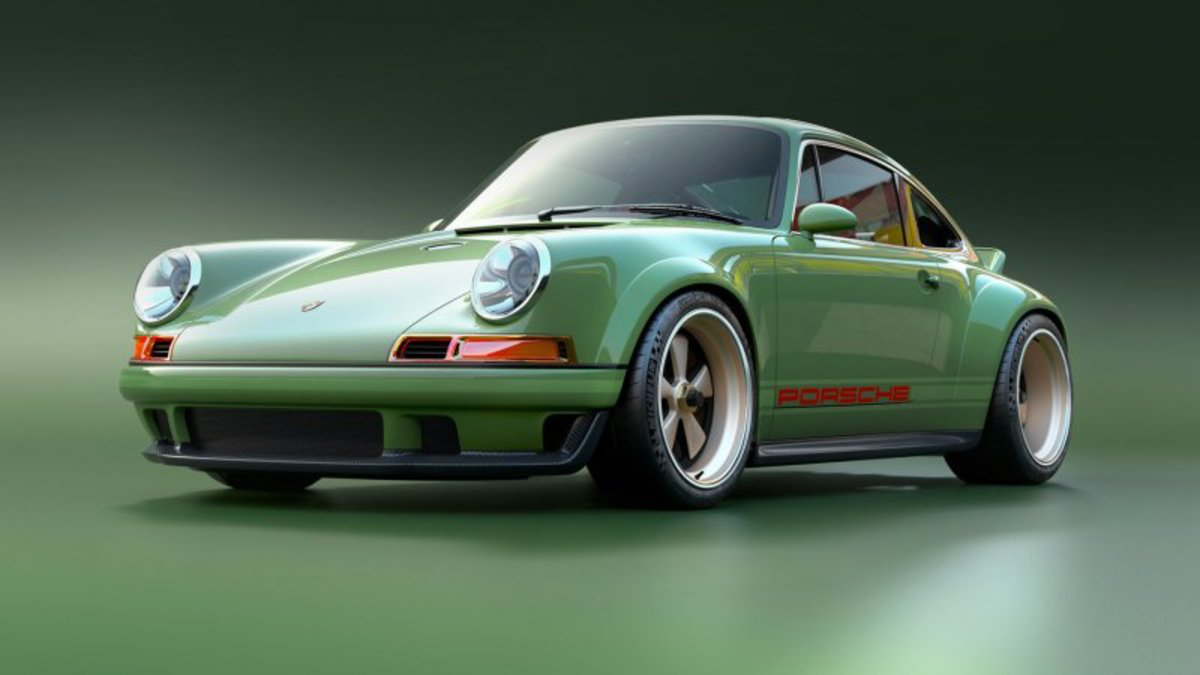

In [8]:
Image.open(image_file)

# Run all 3 types of codes

In [4]:
def calc_ttl_pixels(width, height, recursions):    
    w = width
    h = height
    total_pixels = 0
    for i in range(1,(recursions+1),1):    
        total_pixels = total_pixels + (w*h)
        w = w - 1
        h = h - 1
    return total_pixels

In [30]:
import csv
import time,datetime
recursions = [500]
print('ts,\trcrs,\tpxls,\tcalced,\t\t',end='', flush=True)
print('g_sec,\tg_per_sec,\t',end='', flush=True)
print('cpp_sec,\tcpp_p_sec,\tp_sec,\tpy_p_sec',end='', flush=True)
print()

with open('./results/py_v_cpp_v_gpu.2.csv', mode='w') as py_cpp_gpu:
    py_cpp_gpu_writer = csv.writer(py_cpp_gpu, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    py_cpp_gpu_writer.writerow(['time','recursion_count','image_size','pixels_calculated',
                                'gpu_seconds','gpu_pixels_per_second',
                                'cpp_seconds','cpp_pixels_per_second',
                                'python_seconds','python_pixels_per_second'])
    for recurse_cnt in recursions:

        # timestamp
        cur = time.time()
        dt = datetime.datetime.fromtimestamp(cur).strftime('%H:%M')
        print(dt,   end='', flush=True)
        print(',\t',   end='', flush=True)
        
        # recurse cnt
        print(recurse_cnt, end='', flush=True)
        print(',\t',   end='', flush=True)
        
        # pxls
        ttl = height*width    
        print(ttl, end='', flush=True)
        print(',\t',   end='', flush=True)

        # pxls calced
        ttl_pixels_calced = calc_ttl_pixels(width, height, recurse_cnt)
        print(ttl_pixels_calced, end='', flush=True)        
        print(',\t',   end='', flush=True)    
        if recurse_cnt < 3:
            print('\t',   end='', flush=True)            


        g_start = time.time()
        gpu_conv = native_recurse_pooling(green, width, recurse_cnt, False, gpu_function_ptr)    
        g_secs = time.time() - g_start
            
        # gpu time
        print(round(g_secs,2), end='', flush=True)
        print(',\t',   end='', flush=True)
            
        # gpu pxls per sec
        g_per_sec = ttl_pixels_calced/g_secs
        print(round(g_per_sec,2), end='', flush=True)
        print(',\t',   end='', flush=True)
        
        start = time.time()
        cpp_conv = native_recurse_pooling(green, width, recurse_cnt, False, cpp_function_ptr)    
        cpp_secs = time.time() - start   

        # cpp time
        print(round(cpp_secs,2), end='', flush=True)
        print(',\t\t',   end='', flush=True)

        # cpp pxls per sec
        cpp_per_sec = ttl_pixels_calced/cpp_secs
        print(round(cpp_per_sec), end='', flush=True)
        print(',\t',   end='', flush=True)

        start = time.time()
        py_conv = PY_recurse_pooling(green, width, np.mean, recurse_cnt)    
        py_secs = time.time() - start

        # py time
        print(round(py_secs,2), end='', flush=True)
        print(',\t',   end='', flush=True)

        #py pxls per sec
        py_pxls_per_sec = ttl_pixels_calced/py_secs
        print(round(py_pxls_per_sec), end='', flush=True)

        print()    
        py_cpp_gpu_writer.writerow([cur,recurse_cnt,ttl,ttl_pixels_calced,
                                    g_secs, g_per_sec,
                                 cpp_secs,cpp_per_sec,py_secs,py_pxls_per_sec])    

    py_cpp_gpu.flush()
    py_cpp_gpu.close()

height: 675
width 1200
ts,	rcrs,	pxls,	calced,		g_sec,	g_per_sec,	
17:16,	500,	810000,	212635500,	0.15,	1376617131.72,	
17:16,	600,	810000,	220882600,	0.16,	1420704905.97,	


# Load Results into Dataframe

In [24]:
import pandas as pd
df = pd.read_csv('./results/gpu.csv')

In [25]:
df

,time,recursion_count,image_size,pixels_calculated,gpu_seconds,gpu_pixels_per_second,cpp_seconds,cpp_pixels_per_second,python_seconds,python_pixels_per_second
0,1.554406e+09,500,810000,212635500,0.152472,1.394591e+09,58.215669,3.652548e+06,3560.143256,59726.669599


# NEXT - Visualizing Results

http://localhost:8888/notebooks/7_Visualizing_GPU_CPP_Python.ipynb

![ridic gpu](./imgs/bokeh_gpu_plot.png)